In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import cmcrameri.cm as cm
import time
import os
import sys

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric as tg
import torch_scatter

from ase import Atom, Atoms
from ase.data import atomic_numbers, atomic_masses, covalent_radii
from ase.neighborlist import neighbor_list

from pymatgen.core.structure import Structure

from e3nn.io import CartesianTensor
from e3nn.o3 import ReducedTensorProducts

from torch_geometric.utils import unbatch

from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

from utils.e3nn import E3NN

# Visual formatting for progress bars and plots
bar_format = '{l_bar}{bar:10}{r_bar}{bar:-10b}'
tqdm.pandas(bar_format=bar_format)

sns.set(font_scale=1, style='ticks')
plt.rcParams['font.family'] = 'lato'
plt.rcParams['axes.linewidth'] = 1
plt.rcParams['mathtext.default'] = 'regular'

# PyTorch settings
default_dtype = torch.float64
torch.set_default_dtype(default_dtype)
device = "cuda:0"

In [2]:
# Load data - the data are saved as a .csv file with (at least) structure and diel columns
data = pd.read_csv('data/minimal_data.csv')
data['structure'] = data['structure'].apply(lambda x: Structure.from_dict(eval(x)))
data['diel'] = data['diel'].apply(eval).apply(np.array)
data

,uid,structure,diel
0,mp-571464_27,"[[ 0.4868262 4.23979238 14.38242511] Rb, [ 3...","[[5.549036, -0.405008, -0.009264], [-0.404785,..."
1,mp-571464_50,"[[ 4.03184443 2.65245327 14.36039091] Rb, [-0...","[[7.950354, 0.023657, 0.179322], [0.022488, 7...."
2,mp-571464_95,"[[ 4.14421429 1.62565413 14.29960042] Rb, [ 0...","[[5.359026, 0.014547, -0.174371], [0.014484, 4..."
3,mp-571464_87,"[[7.8265356 4.83298212 4.72358822] Rb, [3.844...","[[6.297432, 0.00864, 0.126729], [0.008732, 5.8..."
4,mp-571464_8,"[[3.51366515 2.8527313 4.87952517] Rb, [8.001...","[[5.258912, 0.038217, 0.110453], [0.037998, 5...."
...,...,...,...
93,mp-571464_48,"[[3.37649209 1.75451764 4.82359535] Rb, [6.977...","[[5.335509, -0.195767, 0.079282], [-0.195789, ..."
94,mp-571464_41,"[[ 7.92738781 4.48023489 14.66656557] Rb, [ 3...","[[5.257179, 0.08473, 0.209747], [0.084568, 5.4..."
95,mp-571464_65,"[[3.31234304 1.60703144 4.83862694] Rb, [-0.29...","[[6.635441, 0.436101, 0.041657], [0.436927, 6...."
96,mp-571464_22,"[[ 3.3311372 2.02164393 14.54913879] Rb, [ 7...","[[6.318865, 0.050537, 0.051162], [0.054567, 6...."


In [3]:
# Get species and encoding for node descriptors
data['species'] = data['structure'].apply(lambda x: list(set(map(str, x.species))))
species = sorted(list(set(data['species'].sum())))
n_species = list(np.unique(data['species'].sum(), return_counts=True)[1])
Z_max = max([Atom(k).number for k in species])
print('Z_max:', Z_max)

# One-hot encoding atom type and mass
type_encoding = {}
mass_specie = []

for Z in range(1, Z_max + 1):
    specie = Atom(Z)
    type_encoding[specie.symbol] = Z - 1
    mass_specie.append(atomic_masses[Z])

type_onehot = torch.eye(len(type_encoding))
mass_onehot = torch.diag(torch.tensor(mass_specie))

Z_max: 37


In [4]:
# Process data into torch geometric object storing necessary inputs and outputs
r_max = 4.     # cutoff radius
tij = CartesianTensor("ij=ji")
rtp = ReducedTensorProducts('ij=ji', i='1o')

def build_data(entry, r_max=4.):
    composition = [list(map(str, site.species._data.keys())) for site in entry.structure.sites.copy()]
    occupancy = [list(map(float, site.species._data.values())) for site in entry.structure.sites.copy()]
    symbols = [k[0] for k in composition] # for labeling only, retain first specie if fractional occupancy
    positions = torch.from_numpy(entry.structure.cart_coords.copy())
    lattice = torch.from_numpy(entry.structure.lattice.matrix.copy()).unsqueeze(0)
    struct = Atoms(symbols=symbols, positions=positions.numpy(), cell=lattice.squeeze().numpy(), pbc=True)

    # edge_src and edge_dst are the indices of the central and neighboring atom, respectively
    # edge_shift indicates whether the neighbors are in different images or copies of the unit cell
    edge_src, edge_dst, edge_shift = neighbor_list("ijS", a=struct, cutoff=r_max, self_interaction=True)

    edge_batch = positions.new_zeros(positions.shape[0], dtype=torch.long)[torch.from_numpy(edge_src)]
    edge_vec = (positions[torch.from_numpy(edge_dst)] - positions[torch.from_numpy(edge_src)]
                + torch.einsum('ni,nij->nj', torch.tensor(edge_shift, dtype=default_dtype), lattice[edge_batch]))
    edge_len = np.around(edge_vec.norm(dim=1).numpy(), decimals=2)

    # compute node features and attributes
    x_node = torch.zeros((len(struct), Z_max))
    z_node = torch.zeros((len(struct), Z_max))
    for i, (comp, occ) in enumerate(zip(composition, occupancy)):
        for specie, k in zip(comp, occ):
            x_node[i,:] += mass_onehot[type_encoding[specie]]      # node feature
            z_node[i,:] += k*type_onehot[type_encoding[specie]]    # atom type (node attribute)

    data = tg.data.Data(
        lattice=lattice, symbol=symbols, pos=positions, x_in=x_node, z_in=z_node,
        y=tij.from_cartesian(torch.from_numpy(entry.diel), rtp=rtp).unsqueeze(0), # output
        edge_shift=torch.tensor(edge_shift, dtype=default_dtype),
        edge_index=torch.stack([torch.LongTensor(edge_src), torch.LongTensor(edge_dst)], dim=0),
        edge_len=edge_len
    )
    return data

tqdm.pandas(desc='Building data', bar_format=bar_format)
data['input'] = data.progress_apply(lambda x: build_data(x, r_max), axis=1)

Building data: 100%|██████████| 98/98 [00:02<00:00, 48.18it/s]                                


In [5]:
# Train/valid split
valid_size = 0.1
seed = 12
idx_train, idx_valid = train_test_split(range(len(data)), test_size=valid_size, random_state=seed)

In [6]:
# Calculate average number of neighbors - needed for normalization of e3nn operations
n = [[],[]]
for k, idx in enumerate([idx_train, idx_valid]):
    for entry in data.iloc[idx].itertuples():
        N = entry.input.pos.shape[0]
        for i in range(N):
            n[k].append(len((entry.input.edge_index[0] == i).nonzero()))
n_train, n_valid = [np.array(k) for k in n]

In [7]:
# Format dataloaders
batch_size = 4

dataloader_train = tg.loader.DataLoader(data.iloc[idx_train]['input'].tolist(), batch_size=batch_size, shuffle=True)
dataloader_valid = tg.loader.DataLoader(data.iloc[idx_valid]['input'].tolist(), batch_size=batch_size)

In [8]:
# Define neural network model on top of E3NN base class (see utils/e3nn for details)
class Model(E3NN):
    def __init__(self, in_dim, emb_dim, num_layers, mul, lmax, max_radius, num_basis,
                 radial_layers, radial_neurons, num_neighbors, has_raman=False):
         
        kwargs = {'reduce_output': False,
                  'irreps_in': str(emb_dim)+"x0e",        # Irrep of input node features
                  'irreps_out': str(tij),                 # Irrep or list of irreps of output node features
                  'irreps_node_attr': str(emb_dim)+"x0e", # Irrep of node attributes
                  'layers': num_layers,
                  'mul': mul,
                  'lmax': lmax,
                  'max_radius': max_radius,
                  'number_of_basis': num_basis,
                  'radial_layers': radial_layers,
                  'radial_neurons': radial_neurons,
                  'num_neighbors': num_neighbors
                 }
        super().__init__(**kwargs)
        
        # Definitions
        self.in_dim = in_dim
        self.emb_dim = emb_dim
        self.num_layers = num_layers
        self.max_radius = max_radius
        self.num_neighbors = num_neighbors
        self.tij = CartesianTensor("ij=ji")
        self.rtp = ReducedTensorProducts('ij=ji', i='1o')
        
        self.model_name = 'e3nn_' + '_'.join(
            i + str(j) if isinstance(j, int) else i + '{:.1f}'.format(j).replace('.','p') for (i,j) in zip(
            ['emb', 'layers', 'mul', 'lmax', 'rmax', 'nbasis', 'rlayers', 'rneurons'],
            [emb_dim, num_layers, mul, lmax, max_radius, num_basis, radial_layers, radial_neurons]))
        
        # Embedding
        self.embed = nn.Linear(in_dim, emb_dim)
    
    
    def forward(self, data):
        # Embed node features and attributes    
        data['x'] = self.embed(data['x_in'])
        data['z'] = self.embed(data['z_in'])
        
        # E(3)NN backbone
        y = super().forward(data)[0]
        
        # Get batch to aggregate nodes per example
        if 'batch' in data:
            batch = data['batch']
        else:
            batch = data['pos'].new_zeros(data['pos'].shape[0], dtype=torch.long)
            
        return torch_scatter.scatter_mean(y, batch, dim=0)
    
    
    def count_parameters(self): 
        return sum(p.numel() for p in self.parameters() if p.requires_grad)
    
    
    def loss(self, y_pred, y_true):
        return nn.MSELoss()(y_pred, y_true)
    
        
    def checkpoint(self, dataloader, device):
        self.eval()
        
        loss_cum = 0.
        with torch.no_grad():
            for j, d in enumerate(dataloader):
                d.to(device)
                y_pred = self.forward(d)
                loss_cum += self.loss(y_pred, d.y).cpu().detach().item()
                
        return loss_cum/len(dataloader)

    
    def fit(self, opt, dataloader_train, dataloader_valid, history, s0, max_iter=10, device="cpu", scheduler=None):
        chkpt = 1

        for step in range(max_iter):
            self.train()

            loss_cum = 0.
            start_time = time.time()

            for j, d in enumerate(dataloader_train):
                d.to(device)
                y_pred = self.forward(d)
                loss = self.loss(y_pred, d.y)
                
                print(f"Iteration {step+1:5d}    batch {j+1:5d} / {len(dataloader_train):5d}   " +
                      f"batch loss = {loss.item():.5e}", end="\r", flush=True)
                
                loss_cum += loss.cpu().detach().item()
                
                opt.zero_grad()
                loss.backward()
                opt.step()
            
            if scheduler is not None:
                scheduler.step()
            
            end_time = time.time()
            wall = end_time - start_time

            if (step+1)%chkpt == 0:
                print(f"Iteration {step+1:5d}    batch {j+1:5d} / {len(dataloader_train):5d}   " +
                      f"epoch loss = {loss_cum/len(dataloader_train):.5e}")

                loss_valid = self.checkpoint(dataloader_valid, device)
                loss_train = self.checkpoint(dataloader_train, device)

                history.append({
                    'step': step + s0,
                    'wall': wall,
                    'batch': {
                        'loss': loss.item(),
                    },
                    'valid': {
                        'loss': loss_valid,
                    },
                     'train': {
                         'loss': loss_train,
                     },
                })

                yield {
                    'history': history,
                    'state': self.state_dict(),
                    'optimizer': opt.state_dict(),
                    'scheduler': scheduler.state_dict() if scheduler else None
                }

In [9]:
# Instantiate model
args_enn = {'in_dim': Z_max,
            'emb_dim': 64,
            'num_layers': 2,
            'mul': 32,
            'lmax': 2,
            'max_radius': r_max,
            'num_basis': 10,
            'radial_layers': 1,
            'radial_neurons': 100,
            'num_neighbors': n_train.mean(),
            'has_raman': False
           }

enn = Model(**args_enn).to(device)
opt = torch.optim.Adam(enn.parameters(), lr=3e-3)
scheduler = None

model_path = 'models/' + enn.model_name + '.torch'

print(model_path)
print('Number of parameters:', enn.count_parameters())

models/e3nn_emb64_layers2_mul32_lmax2_rmax4p0_nbasis10_rlayers1_rneurons100.torch
Number of parameters: 4187192


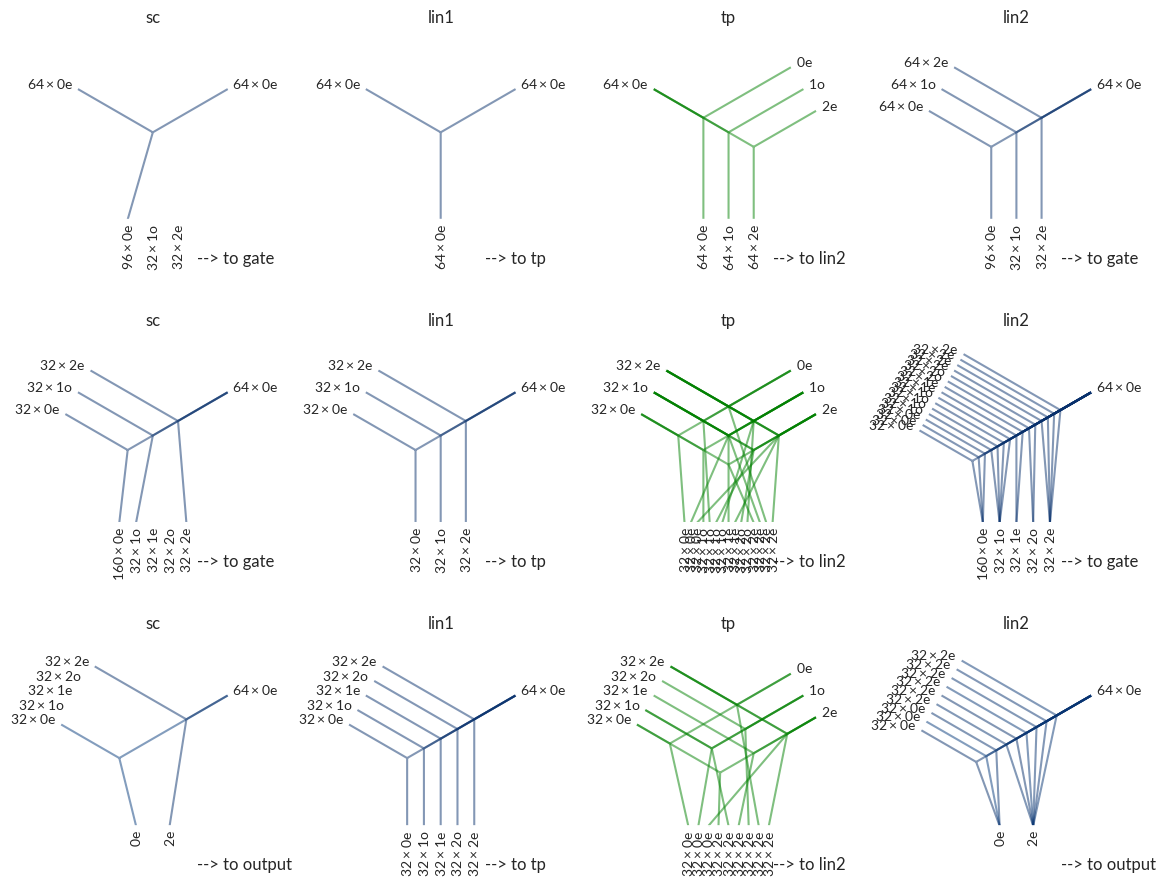

In [10]:
# Visualize E3NN network layers
fig = enn.visualize()

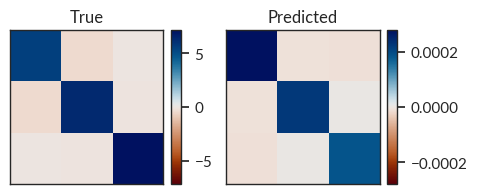

In [11]:
# Evaluate and visualize example data point and prediction
entry = data.iloc[0]
d = tg.data.Batch.from_data_list([entry.input])
with torch.no_grad():
    d.to(device)
    y_pred = enn(d)
    y_pred = enn.tij.to_cartesian(y_pred, enn.rtp).cpu().numpy()[0]

# Plot
fig, ax = plt.subplots(1,5, figsize=(5,2), gridspec_kw={'width_ratios': [1,0.07,0.2,1,0.07]})
plt.subplots_adjust(wspace=0.1)

vmax = np.abs(entry.diel).max()
norm = plt.Normalize(vmin=-vmax, vmax=vmax)
sm = mpl.cm.ScalarMappable(cmap=cm.vik_r, norm=norm)

vmax = np.abs(y_pred).max()
norm_pred = plt.Normalize(vmin=-vmax, vmax=vmax)
sm_pred = mpl.cm.ScalarMappable(cmap=cm.vik_r, norm=norm_pred)

ax[0].imshow(entry.diel, cmap=sm.cmap, norm=sm.norm)
ax[0].set_title('True')

ax[3].imshow(y_pred, cmap=sm.cmap, norm=sm_pred.norm)
ax[3].set_title('Predicted')

ax[0].set_xticks([]); ax[3].set_xticks([])
ax[0].set_yticks([]); ax[3].set_yticks([])

ax[2].remove()
plt.colorbar(sm, cax=ax[1]);
plt.colorbar(sm_pred, cax=ax[-1]);

In [13]:
resume = True # Set to True to load existing model
    
if resume:
    saved = torch.load(model_path, weights_only=True, map_location=device)
    enn.load_state_dict(saved['state'])
    opt.load_state_dict(saved['optimizer'])
    try:
        scheduler.load_state_dict(saved['scheduler'])
    except:
        scheduler = None
    history = saved['history']
    s0 = history[-1]['step'] + 1

else:
    history = []
    s0 = 0

In [20]:
# Fit E3NN
for results in enn.fit(opt, dataloader_train, dataloader_valid, history, s0, max_iter=40, device=device,
                       scheduler=scheduler):
    with open(model_path, 'wb') as f:
        torch.save(results, f)

Iteration     1    batch    22 /    22   epoch loss = 3.32697e-02
Iteration     2    batch    22 /    22   epoch loss = 3.46581e-02
Iteration     3    batch    22 /    22   epoch loss = 5.95936e-02
Iteration     4    batch    22 /    22   epoch loss = 3.51847e-02
Iteration     5    batch    22 /    22   epoch loss = 4.83222e-02
Iteration     6    batch    22 /    22   epoch loss = 8.56734e-02
Iteration     7    batch    22 /    22   epoch loss = 9.39116e-02
Iteration     8    batch    22 /    22   epoch loss = 8.63629e-02
Iteration     9    batch    22 /    22   epoch loss = 2.96799e-02
Iteration    10    batch    22 /    22   epoch loss = 3.04924e-02
Iteration    11    batch    22 /    22   epoch loss = 2.69562e-02
Iteration    12    batch    22 /    22   epoch loss = 3.09066e-02
Iteration    13    batch    22 /    22   epoch loss = 1.88410e-02
Iteration    14    batch    22 /    22   epoch loss = 1.59056e-02
Iteration    15    batch    22 /    22   epoch loss = 3.05039e-02
Iteration 

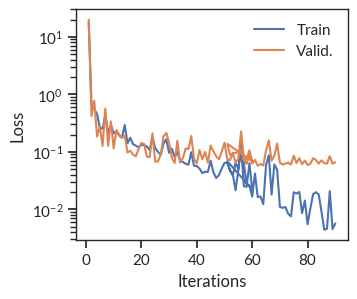

In [21]:
saved = torch.load(model_path, weights_only=True, map_location=device)
history = saved['history']

steps = [d['step'] + 1 for d in history]
loss_train = [d['train']['loss'] for d in history]
loss_valid = [d['valid']['loss'] for d in history]

fig, ax = plt.subplots(figsize=(3.5,3))
ax.plot(steps, loss_train, label='Train', color='C0')
ax.plot(steps, loss_valid, label='Valid.', color='C1')
ax.set_xlabel('Iterations')
ax.set_ylabel('Loss')
ax.set_yscale('log')
ax.legend(frameon=False);

In [22]:
# Predict all dielectric and raman tensors
enn.eval()

dataloader = tg.loader.DataLoader(data['input'].tolist(), batch_size=batch_size)
diel_pred = []

with torch.no_grad():
    for j, d in tqdm(enumerate(dataloader), total=len(dataloader), bar_format=bar_format):
        d.to(device)
        _diel_pred = enn(d)
        diel_pred += enn.tij.to_cartesian(_diel_pred, enn.rtp).cpu().numpy().tolist()
    
data['diel_pred'] = diel_pred

100%|██████████| 25/25 [00:00<00:00, 88.13it/s]                                               


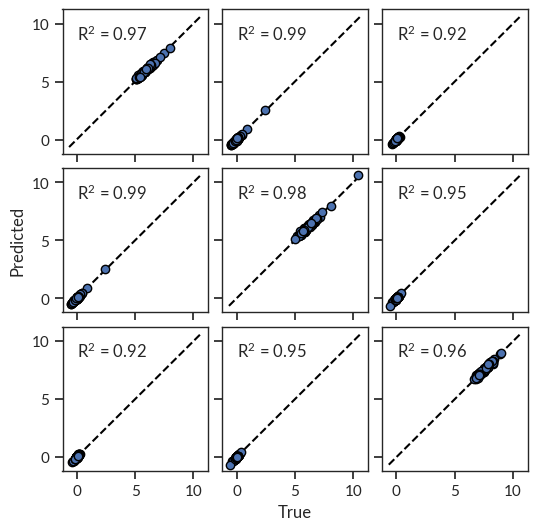

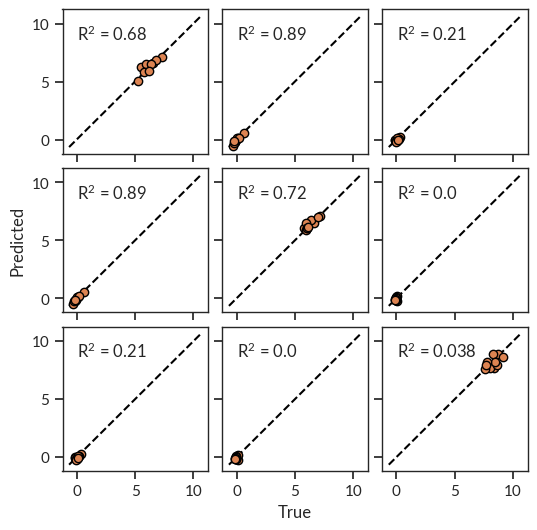

In [23]:
# Plot predictions
for k, (idx, color) in enumerate(zip([idx_train, idx_valid], ['C0', 'C1'])):
    fig, ax = plt.subplots(3,3, figsize=(3*2,3*2), sharex=True, sharey=True)
    fig.subplots_adjust(wspace=0.1, hspace=0.1)

    x = np.stack(data.iloc[idx]['diel'])
    y = np.stack(data.iloc[idx]['diel_pred'])
    
    if k == 0:
        d_min = min(x.min(), y.min())
        d_max = max(x.max(), y.max())

    for i in range(3):
        for j in range(3):
            ax[i,j].plot([d_min, d_max], [d_min, d_max], color='black', ls='dashed')
            ax[i,j].scatter(x[:,i,j], y[:,i,j], ec='black', zorder=2, color=color)
            r2 = max(0., r2_score(x[:,i,j], y[:,i,j]))
            ax[i,j].text(0.1, 0.9, '$R^2$ = {:.2}'.format(r2), ha='left', va='top', transform=ax[i,j].transAxes)
            ax[i,j].locator_params(axis='both', nbins=4)
    
    ax[-1,1].set_xlabel('True')
    ax[1,0].set_ylabel('Predicted')